## Deep-Unfolded Gradient Descent (DUGD) for least mean square problems

* This code is used to generate Figure 1 in the following manuscript:

S. Takabe and T. Wadayama, "Convergence Acceleration via Chebyshev Step:  Plausible Interpretation of Deep-Unfolded Gradient Descent"




In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math

device = torch.device('cuda') # 'cpu' or 'cuda'

In [12]:
## model parameters 
itr = 25 # iteration steps $T$
total_itr = itr # max. iterations
n = 300 
m = 600 
##

## training parameters
bs = 200 # mini batch size
num_batch = 500 # number of mini batches
lr_adam = 0.002 # learning rate of optimizer
init_val = 0.3 # initial values of $\gamma_t$
##

## parameters for evauation of generalization error 
total_itr=25 # total number of iterations (multiple number of "itr")
bs = 10000 # number of samples 
##

## 目的関数の定義

In [6]:
# generate A and H
seed_ = 12
np.random.seed(seed=seed_)
H = np.random.normal(0,1.0/math.sqrt(n),(n,m)) 
A = np.dot(H,H.T)
eig = np.linalg.eig(A)
eig = eig[0] # eigenvalues

W = torch.Tensor(np.diag(eig)).to(device)
H = torch.from_numpy(H).float().to(device)

print("condition number, min. and max. eigenvalues of A")
print(np.max(eig)/np.min(eig),np.max(eig),np.min(eig))


condition number, min. and max. eigenvalues of A
30.828752475023858 5.678370598467161 0.18419073567986688


In [7]:
# gradient
def grad_numerical_f(x, bs):
    return (x@H-y)@H.T # A^T(Ax-y)

## DUGD 
class DUGD(nn.Module):
    def __init__(self, num_itr):
        super(DUGD, self).__init__()
        self.gamma = nn.Parameter(init_val*torch.ones(num_itr))
    def forward(self, num_itr, bs):
        traj = []
        s = torch.zeros(bs,n).to(device) # initial point
        traj.append(s)
        for i in range(num_itr):
            j = i % itr
            s = s - abs(self.gamma[j]) * grad_numerical_f(s, bs)
            traj.append(s)
        return s, traj

model = DUGD(itr).to(device)
loss_func = nn.MSELoss()
opt   = optim.Adam(model.parameters(), lr=lr_adam)

In [8]:
## training process of DUGD
# it takes about several minutes on Google Colaboratory

loss_gen=[]
for gen in (range(itr)): # incremental training
    for i in range(num_batch):
        opt.zero_grad()
        solution = torch.normal(0.0*torch.ones(bs,n),1.0).to(device)
        y = solution @ H
        x_hat,_ = model(gen + 1, bs)
        loss  = loss_func(x_hat, solution)
        loss.backward()
        opt.step()
        if i % 200 == 0:
            print("generation:",gen+1, " batch:",i, "\t MSE loss:",loss.item() )
    loss_gen.append(loss.item())
    

generation: 1  batch: 0 	 MSE loss: 0.3401855528354645
generation: 1  batch: 200 	 MSE loss: 0.33376988768577576
generation: 1  batch: 400 	 MSE loss: 0.33350440859794617
generation: 2  batch: 0 	 MSE loss: 0.1866937130689621
generation: 2  batch: 200 	 MSE loss: 0.14293411374092102
generation: 2  batch: 400 	 MSE loss: 0.14281947910785675
generation: 3  batch: 0 	 MSE loss: 0.08867742866277695
generation: 3  batch: 200 	 MSE loss: 0.06666599214076996
generation: 3  batch: 400 	 MSE loss: 0.06647271662950516
generation: 4  batch: 0 	 MSE loss: 0.04321271553635597
generation: 4  batch: 200 	 MSE loss: 0.03373166546225548
generation: 4  batch: 400 	 MSE loss: 0.032688163220882416
generation: 5  batch: 0 	 MSE loss: 0.021908778697252274
generation: 5  batch: 200 	 MSE loss: 0.017499318346381187
generation: 5  batch: 400 	 MSE loss: 0.01661672070622444
generation: 6  batch: 0 	 MSE loss: 0.011644154787063599
generation: 6  batch: 200 	 MSE loss: 0.009115904569625854
generation: 6  batch: 4

In [9]:
# learned gamma
print("#_ n=", n, "m=",m, "itr=",itr, "bs=", bs, "num_batch=", num_batch,
      "learning_rate=", lr_adam,"seed=",seed_ ,"lmax=", np.max(eig),"lmin=", np.min(eig), "kappa=",np.max(eig)/np.min(eig),"init_val=",init_val  )
print("#_ t, learned $\gamma_t$")
for i in range(itr):
    print(i+1, model.gamma[i].item())

#_ n= 300 m= 600 itr= 25 bs= 10000 num_batch= 500 learning_rate= 0.002 seed= 12 lmax= 5.678370598467161 lmin= 0.18419073567986688 kappa= 30.828752475023858 init_val= 0.3
#_ t, learned $\gamma_t$
1 2.7968475818634033
2 0.15829326212406158
3 2.7523624897003174
4 0.1761307716369629
5 2.6692168712615967
6 0.17889799177646637
7 2.402275323867798
8 0.18407782912254333
9 2.0441930294036865
10 0.19884438812732697
11 1.7192271947860718
12 0.19049596786499023
13 1.1071189641952515
14 0.20766183733940125
15 0.8196592330932617
16 0.21995534002780914
17 0.6515235304832458
18 0.23534350097179413
19 0.5379718542098999
20 0.2542450726032257
21 0.4552152156829834
22 0.30794599652290344
23 0.2782919704914093
24 0.392377644777298
25 0.3454958498477936


In [13]:
## naive GD with a constant step size 
class GD(nn.Module):
    def __init__(self, num_itr):
        super(GD, self).__init__()
    def forward(self, num_itr, bs, gamma):
        traj = []
        s  = torch.zeros(bs,n).to(device)
        traj.append(s)

        for i in range(num_itr):
            s = s - abs(gamma) * grad_numerical_f(s, bs)
            traj.append(s)
        return s, traj
gd_model = GD(itr).to(device)


In [19]:
## Evaluation of c error

solution = torch.normal(0.0*torch.ones(bs,n),1.0).to(device).detach()
y = solution@H.detach()

## trained DUGD

norm_list_DUGD = []
itr_list = []
for i in range(total_itr+1):
    s_hat,_ = model(i, bs)
    err = (torch.norm(solution.to(device) - s_hat.to(device))**2).item()/(n*bs)
    norm_list_DUGD.append(err)
    itr_list.append(i)

## naive GD 
gamma = 2.0/(np.max(eig)+np.min(eig)) # optimal constant step size
norm_list_GD = []
for i in range(total_itr+1):

    s_hat, _ = gd_model(i, bs, gamma)
    err = (torch.norm(solution.to(device) - s_hat.to(device))**2).item()/(n*bs)
    norm_list_GD.append(err)


# generalization error (MSE)
print("#_ generalization error (MSE)")
print("#_ itr, DUGD, GD")
for i in range(total_itr+1):
    print(i,"{:.5e} {:.5e}".format(norm_list_DUGD[i], norm_list_GD[i]) )

#_ generalization error (MSE)
#_ itr, DUGD, GD
0 9.99259e-01 9.99259e-01
1 3.64287e+01 3.33011e-01
2 6.95999e+00 1.85002e-01
3 3.86486e+02 1.19195e-01
4 5.97057e+01 8.27140e-02
5 3.00187e+03 6.00709e-02
6 5.19255e+02 4.49974e-02
7 2.01890e+04 3.44702e-02
8 3.47021e+03 2.68579e-02
9 9.06827e+04 2.12066e-02
10 1.31697e+04 1.69242e-02
11 2.15415e+05 1.36256e-02
12 3.78916e+04 1.10507e-02
13 1.92627e+05 9.01827e-03
14 2.60609e+04 7.39916e-03
15 5.13028e+04 6.09905e-03
16 5.69392e+03 5.04796e-03
17 4.70849e+03 4.19315e-03
18 3.90736e+02 3.49435e-03
19 1.30250e+02 2.92046e-03
20 7.00819e+00 2.44721e-03
21 7.92635e-01 2.05554e-03
22 6.72113e-03 1.73031e-03
23 3.32633e-04 1.45943e-03
24 3.29349e-06 1.23322e-03
25 3.86385e-07 1.04384e-03


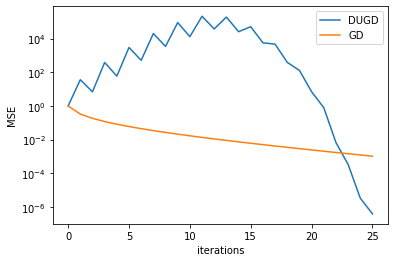

In [23]:
import matplotlib.pyplot as plt

plt.plot(itr_list, norm_list_DUGD, label="DUGD")
plt.plot(itr_list, norm_list_GD, label="GD")
plt.xlabel('iterations')
plt.ylabel('MSE')
plt.yscale('log')
plt.legend()
plt.show()